<div class="warning" style='background-color:#15DB69; color:#000000; border-left: solid #004C23 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:center'>
<b>Projet Empow'her - exploration des données INSEP</b></p>
<p style='margin-left:1em;'>
Bonjour et bienvenu à cet atelier datacraft en collaboration avec l'INSEP.<br><br>
    
</p>
<p style='margin-bottom:1em; margin-right:1em; text-align:right; font-family:Georgia'> <b>- L'équipe datacraft</b> <i>(pour l'atelier INSEP du 14 avril 2022)</i>
</p></span>
</div>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as clrs

from sklearn import preprocessing #ajout du numéro 

import time
import os
import pickle5

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

%run utils.ipynb

In [2]:
def plot_df_1day_time_series(df_loc, x_qtty="Timestamp", qtties_plot=["heart_rate"], tuple_figsize=(22.,12.), shade_area=False):
    list_of_colors = ['#33FFFF', '#00FF00', '#CCCC00', '#FF9966', '#CC3366', '#99CCCC', '#CC66CC', '#66FF99', '#FFFF66', '#6600FF', '#006699', '#CC9966', '#3366FF', '#FF3366', '#000000']

    fig, ax = plt.subplots(nrows=len(qtties_plot), figsize=tuple_figsize, sharex=True)

    for ctr, (y_qtty, color) in enumerate(zip(qtties_plot, list_of_colors)):
        df_loc.plot(x=x_qtty, y=y_qtty, color=color, ax=ax[ctr])
        ax[ctr].set_ylabel(y_qtty)
        if shade_area :
            df_loc.plot.area(x=x_qtty, y=y_qtty, color=color, alpha=0.2, ax=ax[ctr])
        plt.subplots_adjust(hspace = .001)

In [3]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))


In [4]:
import pickle5 as pickle

def load_df_pickle(fpath):
    with open(fpath, "rb") as fh:
      return pickle.load(fh)

---

Chargement des jeux de données
---

In [35]:
t_start = time.time()

df_ath1 = pd.read_pickle("/workspace/data/df_ath1_full.pkl")
df_ath2 = pd.read_pickle("/workspace/data/df_ath2_full.pkl")

df_morning_ath1 = pd.read_pickle("/workspace/data/df_ath1_morning.pkl")
df_morning_ath2 = pd.read_pickle("/workspace/data/df_ath2_morning.pkl")

print(f"Time taken: {time.time()-t_start}")

Time taken: 0.7591085433959961


### Focus on Athlete 1

In [36]:
df_ath1.columns.unique()

Index(['Timestamp', 'tps', 'date', 'training_counter', 'day_index',
       'training_index', 'type_ent', 'day_cycle', 'phase', 'activite', 'duree',
       'rpe', 'kcal_cst', 'id', 'dist_totale_cst', 'mean_power', 'max_power',
       'mean_hr', 'name', 'latitude', 'longitude', 'altitude', 'temperature',
       'heart_rate', 'speed_meters_per_sec', 'power_watts', 'bike_cadence',
       'distance_cumul', 'add_tps'],
      dtype='object')

In [37]:
df_reduced = filter_df(df_ath1, qtty="type_ent", filtre={'kind':'include', 'list':['endurance', 'race', 'intervals', 'recovery','warmup', 'ride', 'intensity']})

In [39]:
list_integrals = list()
lags = np.arange(0,50)

for this_id in df_reduced.training_counter.unique():
    sub_df = df_reduced[df_reduced['training_counter']==this_id]
    
    x = np.diff(sub_df.heart_rate.interpolate())
    y = sub_df.power_watts.fillna(0)
    integral = np.trapz(y[1:],x=x)
    
    smooth_hr = sub_df.heart_rate.interpolate().rolling(5).mean()
    smooth_watts = sub_df.power_watts.fillna(0).rolling(5).mean()
    rs = [crosscorr(smooth_hr, smooth_watts, lag=ii) for ii in lags]
    
    
    list_integrals.append({'counter': this_id,
                           'type':sub_df.type_ent.iloc[0],
                           'integral':integral,
                           'date':sub_df.date.iloc[0],
                           'temperature': sub_df.temperature.mean(),
                           'duree':sub_df.duree.iloc[0],
                           'lag':lags[np.argmax(np.abs(rs))],
                           'max_corr':np.max(rs),
                           'rpe':sub_df['rpe'].iloc[0]
                          })

<AxesSubplot:>

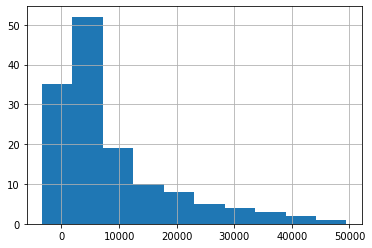

In [40]:
df_integrals = pd.DataFrame(list_integrals)

df_integrals['integral'].hist()

In [41]:
sub_df.columns

Index(['Timestamp', 'tps', 'date', 'training_counter', 'day_index',
       'training_index', 'type_ent', 'day_cycle', 'phase', 'activite', 'duree',
       'rpe', 'kcal_cst', 'id', 'dist_totale_cst', 'mean_power', 'max_power',
       'mean_hr', 'name', 'latitude', 'longitude', 'altitude', 'temperature',
       'heart_rate', 'speed_meters_per_sec', 'power_watts', 'bike_cadence',
       'distance_cumul', 'add_tps'],
      dtype='object')

In [42]:
df_integrals[df_integrals['integral']>20000]

,counter,type,integral,date,temperature,duree,lag,max_corr,rpe
23,24,race,21035.000000,2021-05-08,25.581235,135.8,20,0.722793,80.0
40,41,race,43800.778540,2021-05-29,26.205576,208.1,21,0.669971,80.0
49,50,race,26902.250000,2021-06-06,12.353262,135.1,19,0.778162,70.0
56,57,race,49476.476923,2021-06-12,30.862379,100.1,15,0.494735,80.0
63,64,race,39532.500000,2021-06-20,18.139844,81.3,14,0.549915,80.0
72,75,race,36402.478836,2021-07-04,15.084776,156.9,19,0.721482,50.0
82,86,race,25438.746784,2021-07-24,19.758807,113.8,19,0.601801,80.0
88,92,race,27958.917678,2021-07-31,16.189893,148.3,18,0.722581,70.0
100,106,race,31009.000000,2021-08-29,20.686224,122.4,18,0.597626,70.0
106,112,race,24825.000000,2021-09-05,29.897313,142.7,18,0.604118,70.0


<AxesSubplot:xlabel='rpe', ylabel='lag'>

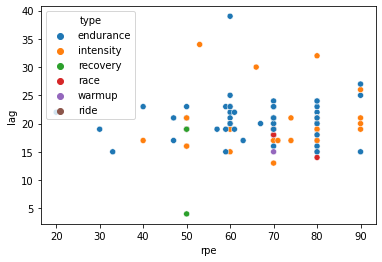

In [122]:
sns.scatterplot(df_integrals['rpe'], df_integrals['lag'], hue=df_integrals['type'])


In [44]:
df_integrals['is_winter']=df_integrals['date']>pd.to_datetime('2021-12-01')

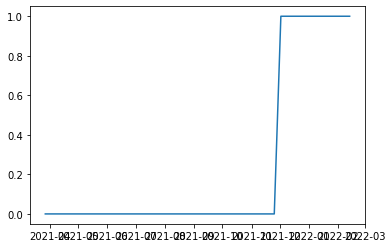

In [45]:
plt.plot(df_integrals.date,df_integrals.is_winter)

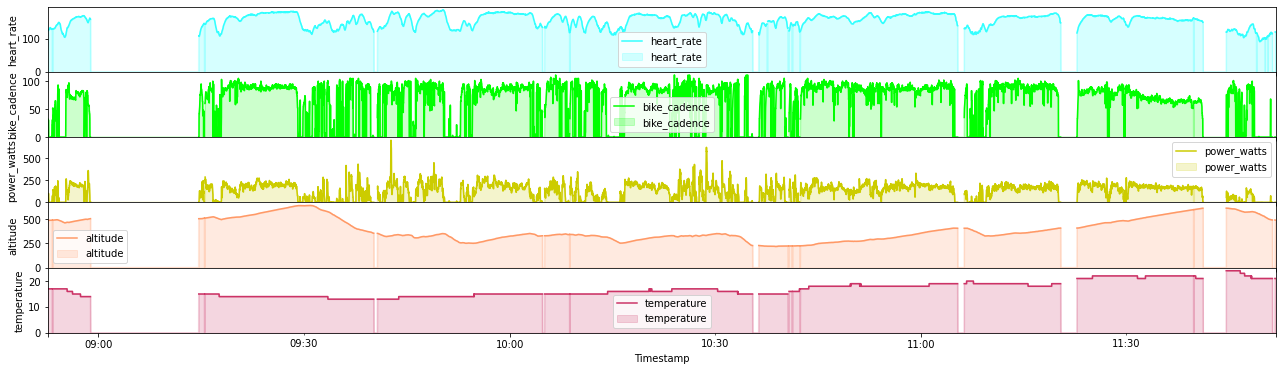

In [46]:
list_to_plot = ["heart_rate", "bike_cadence", "power_watts", "altitude", "temperature"]

sub_df = filter_df(df_ath1, qtty="training_counter", filtre={'kind':'include', 'list':[42]})

plot_df_1day_time_series(sub_df, x_qtty="Timestamp", qtties_plot=list_to_plot, tuple_figsize=(22.,6.), shade_area=True)

In [47]:
sub_df

,Timestamp,tps,date,training_counter,day_index,training_index,type_ent,day_cycle,phase,activite,...,latitude,longitude,altitude,temperature,heart_rate,speed_meters_per_sec,power_watts,bike_cadence,distance_cumul,add_tps
312297,2021-05-30 08:52:38,1,2021-05-30,42,36,1,endurance,12,Folliculaire,ROAD_BIKING,...,NaN,NaN,485.6,17.0,124.0,NaN,68.0,25.0,0.000,0.0
312298,2021-05-30 08:52:39,2,2021-05-30,42,36,1,endurance,12,Folliculaire,ROAD_BIKING,...,NaN,NaN,485.8,17.0,124.0,NaN,76.0,32.0,0.000,0.0
312299,2021-05-30 08:52:40,3,2021-05-30,42,36,1,endurance,12,Folliculaire,ROAD_BIKING,...,NaN,NaN,485.8,17.0,125.0,NaN,82.0,32.0,0.000,0.0
312300,2021-05-30 08:52:41,4,2021-05-30,42,36,1,endurance,12,Folliculaire,ROAD_BIKING,...,NaN,NaN,485.8,17.0,125.0,NaN,90.0,30.0,0.000,0.0
312301,2021-05-30 08:52:42,5,2021-05-30,42,36,1,endurance,12,Folliculaire,ROAD_BIKING,...,NaN,NaN,485.8,17.0,126.0,NaN,100.0,30.0,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323041,2021-05-30 11:51:42,10745,2021-05-30,42,36,1,endurance,12,Folliculaire,ROAD_BIKING,...,46.101,4.307,488.6,21.0,NaN,2.230,0.0,0.0,66337.258,0.0
323042,2021-05-30 11:51:43,10746,2021-05-30,42,36,1,endurance,12,Folliculaire,ROAD_BIKING,...,46.101,4.308,488.4,21.0,120.0,2.137,0.0,0.0,66339.227,0.0
323043,2021-05-30 11:51:44,10747,2021-05-30,42,36,1,endurance,12,Folliculaire,ROAD_BIKING,...,46.101,4.308,488.0,21.0,120.0,0.933,0.0,0.0,66340.562,0.0
323044,2021-05-30 11:51:45,10748,2021-05-30,42,36,1,endurance,12,Folliculaire,ROAD_BIKING,...,46.101,4.308,487.8,21.0,120.0,0.000,0.0,0.0,66340.562,0.0


In [50]:
X = df_integrals.dropna()
#X = X[X['type']!='race']
X = X.drop(columns=['date', 'counter', 'type', 'max_corr','is_winter'])#,'conformity_score'])
X.rpe.fillna('mean', inplace=True)

In [49]:
X.head()

,integral,temperature,duree,lag,rpe
0,3983.908638,9.429615,66.1,22,80.0
1,2147.481016,12.808407,109.4,22,20.0
2,4327.000000,4.074587,150.4,20,80.0
3,1210.500000,11.335703,65.6,20,90.0
4,7798.000000,14.442165,112.0,21,50.0


In [20]:
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

In [51]:
anomaly_model = IsolationForest()

In [52]:
anomaly_model.fit(X)

IsolationForest()

In [53]:
anomaly_model.predict(X)

array([ 1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1,  1, -1,  1,  1,
        1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1, -1, -1, -1])

In [54]:
X['conformity_score'] = ['inlier' if _ >0 else 'outlier' for _ in anomaly_model.predict(X)]

<AxesSubplot:xlabel='rpe', ylabel='integral'>

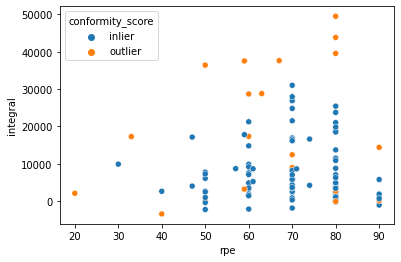

In [56]:
sns.scatterplot(X['rpe'], X['integral'], hue=X['conformity_score'])

<AxesSubplot:xlabel='duree', ylabel='lag'>

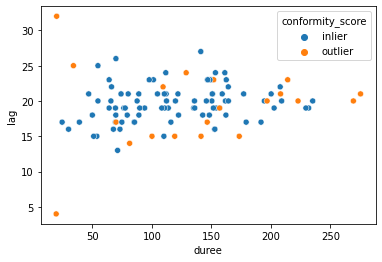

In [57]:
sns.scatterplot(X['duree'], X['lag'], hue=X['conformity_score'])

In [58]:
x_small = PCA(n_components=2).fit_transform(X.drop(columns='conformity_score'))

<AxesSubplot:>

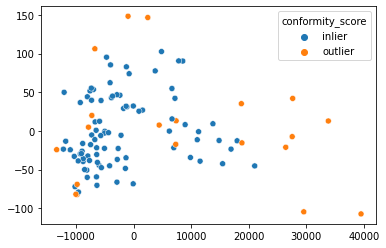

In [59]:
sns.scatterplot(x_small[:,0], x_small[:,1], hue=X['conformity_score'])

In [60]:
df_integrals.loc[:,'conformity_score'] =X['conformity_score']

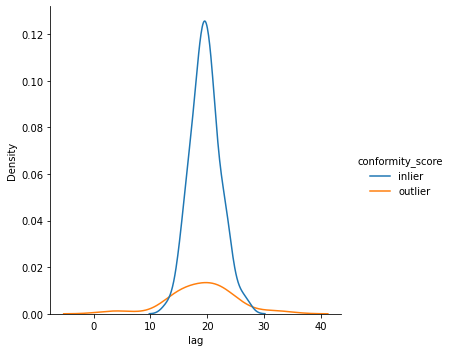

In [63]:
sns.displot(x='lag', data=df_integrals, hue='conformity_score',kind='kde')

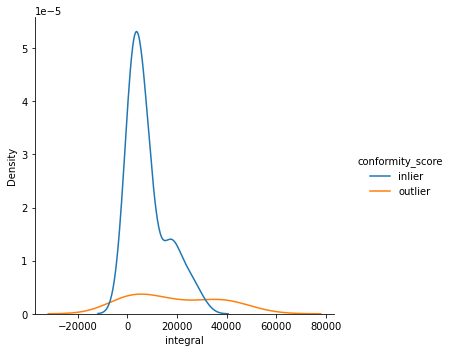

In [62]:
sns.displot(x='integral', data=df_integrals, hue='conformity_score',kind='kde')

<AxesSubplot:xlabel='rpe', ylabel='integral'>

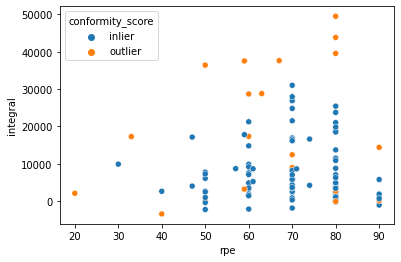

In [74]:
sns.scatterplot(x='rpe',y='integral', data=df_integrals, hue='conformity_score')

In [75]:
df_morning_ath1

,date,about,heure_couche,heure_leve,nb_heure_sommeil,qualite_sommeil,ressentit_global,ressentit_emotion,symptomes,poids,blessures_douleurs,zone_de_douleur,douleur_gene,intensite_douleur,type_douleur,symptomes_enc,blessures_enc,zone_douleur_enc,douleur_enc,type_douleur_enc
0,2022-01-03,Athlete_1,21:30:00,08:15:00,10.75,6.0,7.0,7.0,[Aucun],54.7,Aucune,Aucune,Aucune,0 - Sans blessure/douleur,Aucun,2,0,0,0,1
1,2022-01-02,Athlete_1,22:00:00,09:00:00,11.00,8.0,8.0,8.0,[Aucun],NaN,Aucune,Aucune,Aucune,0 - Sans blessure/douleur,Aucun,2,0,0,0,1
2,2022-01-29,Athlete_1,22:00:00,07:30:00,9.50,5.0,7.0,8.0,[Aucun],54.9,Aucune,Aucune,Aucune,0 - Sans blessure/douleur,Aucun,2,0,0,0,1
3,2022-01-26,Athlete_1,22:30:00,06:15:00,7.75,9.0,8.0,8.0,[Aucun],55.2,Aucune,Aucune,Aucune,0 - Sans blessure/douleur,Aucun,2,0,0,0,1
4,2022-01-24,Athlete_1,22:15:00,06:45:00,8.50,8.0,6.0,7.0,[Aucun],55.2,Aucune,Aucune,Aucune,0 - Sans blessure/douleur,Aucun,2,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2021-07-04,Athlete_1,00:00:00,08:30:00,8.50,6.0,7.0,8.0,[Maux de tête],55.0,Aucune,Aucune,Aucune,0 - Sans blessure/douleur,NaN,5,0,0,0,1
146,2021-07-04,Athlete_1,00:00:00,08:30:00,8.50,6.0,7.0,8.0,[Maux de tête],55.0,Aucune,Aucune,Aucune,0 - Sans blessure/douleur,NaN,5,0,0,0,1
147,2021-07-04,Athlete_1,00:00:00,08:30:00,8.50,6.0,7.0,8.0,[Maux de tête],NaN,Aucune,Aucune,Aucune,0 - Sans blessure/douleur,NaN,5,0,0,0,1
148,2021-07-04,Athlete_1,00:00:00,08:30:00,8.50,6.0,7.0,8.0,[Maux de tête],NaN,Aucune,Aucune,Aucune,0 - Sans blessure/douleur,NaN,5,0,0,0,1


### Focus Athlete 2

In [94]:
list_integrals = list()
lags = np.arange(0,50)

for this_id in df_ath2.training_counter.unique():
    sub_df = df_ath2[df_ath2['training_counter']==this_id]
    
    x = np.diff(sub_df.heart_rate.interpolate())
    y = sub_df.power_watts.fillna(0)
    integral = np.trapz(y[1:],x=x)
    
    smooth_hr = sub_df.heart_rate.interpolate().rolling(5).mean()
    smooth_watts = sub_df.power_watts.fillna(0).rolling(5).mean()
    rs = [crosscorr(smooth_hr, smooth_watts, lag=ii) for ii in lags]
    
    
    list_integrals.append({'counter': this_id,
                           'type':sub_df.type_ent.iloc[0],
                           'integral':integral,
                           'date':sub_df.date.iloc[0],
                           'temperature': sub_df.temperature.mean(),
                           'duree':sub_df.duree.iloc[0],
                           'lag':lags[np.argmax(np.abs(rs))],
                           'max_corr':np.max(rs),
                           'rpe':sub_df['rpe'].iloc[0]
                          })
df_integrals_ath2 = pd.DataFrame(list_integrals)
df_integrals_ath2['is_winter']=df_integrals_ath2['date']>pd.to_datetime('2021-12-01')

In [98]:
X = df_integrals_ath2.dropna()
#X = X[X['type']!='race']
X = X.drop(columns=['date', 'counter', 'type', 'max_corr','is_winter'])#, 'conformity_score'])
X.rpe.fillna('mean', inplace=True)

In [99]:
anomaly_model.fit(X)

IsolationForest()

In [100]:
X['conformity_score'] = ['inlier' if _ >0 else 'outlier' for _ in anomaly_model.predict(X)]
df_integrals_ath2.loc[:,'conformity_score'] = X['conformity_score']

<AxesSubplot:xlabel='rpe', ylabel='integral'>

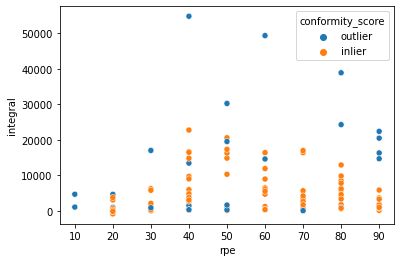

In [102]:
sns.scatterplot(x='rpe',y='integral', data=df_integrals_ath2, hue='conformity_score')

<AxesSubplot:xlabel='temperature', ylabel='lag'>

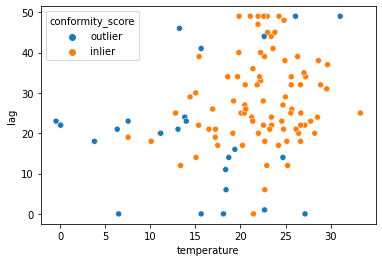

In [104]:
sns.scatterplot(x='temperature',y='lag', data=df_integrals_ath2, hue='conformity_score')

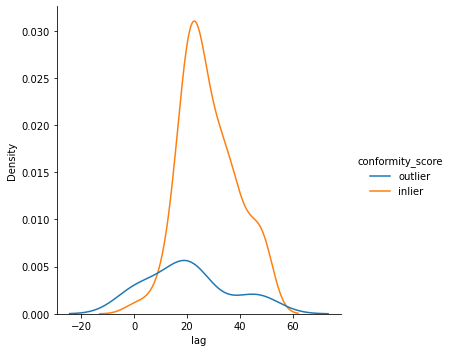

In [105]:
sns.displot(x='lag', data=df_integrals_ath2, hue='conformity_score',kind='kde')

In [109]:
df_integrals_ath2[['counter', 'conformity_score', 'type']]

,counter,conformity_score,type
0,1,outlier,intensity
1,2,outlier,warmup
2,3,NaN,endurance
3,4,inlier,intensity
4,5,inlier,endurance
...,...,...,...
130,131,inlier,recovery
131,132,outlier,intensity
132,133,outlier,intensity
133,134,NaN,intensity


In [114]:
pd.crosstab(df_integrals_ath2['conformity_score'], df_integrals_ath2['type'])

type,endurance,intensity,race,recovery,track,warmup
conformity_score,,,,,,
inlier,31,28,2,5,13,10
outlier,7,12,0,1,1,4


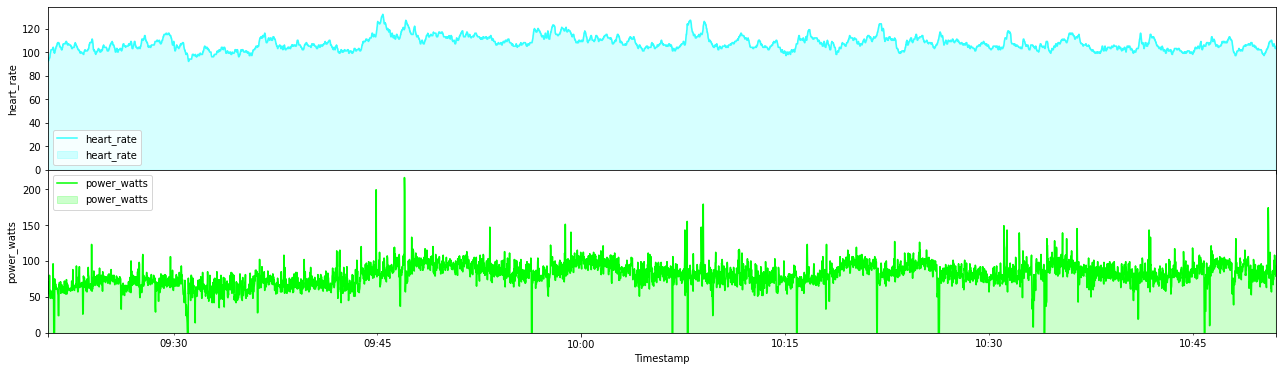

In [118]:
list_to_plot = ["heart_rate", "power_watts"]

sub_df = filter_df(df_ath2, qtty="training_counter", filtre={'kind':'include', 'list':[2]})

plot_df_1day_time_series(sub_df, x_qtty="Timestamp", qtties_plot=list_to_plot, tuple_figsize=(22.,6.), shade_area=True)

In [117]:
df_integrals_ath2[df_integrals_ath2['counter']==2]

,counter,type,integral,date,temperature,duree,lag,max_corr,rpe,is_winter,conformity_score
1,2,warmup,942.0,2021-03-30,18.39797,90.3,6,0.415324,20.0,False,outlier


<AxesSubplot:xlabel='date', ylabel='integral'>

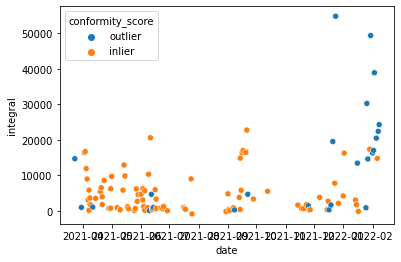

In [121]:
sns.scatterplot(df_integrals_ath2.date,df_integrals_ath2.integral, df_integrals_ath2.conformity_score)

<AxesSubplot:xlabel='date', ylabel='integral'>

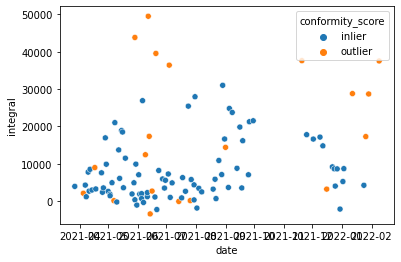

In [125]:
sns.scatterplot(df_integrals.date,df_integrals.integral, df_integrals.conformity_score)